<h1>CSCA 5642 Week 5 Project: Monet GAN</h1>

<h2>1. Problem, Goals and Data</h2>

This week's challenge problem is the Kaggle competition "[I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)," which involves building and training a generative adversarial network to add a "Monet style" to photos. Generative adversarial networks, or GANs, are a good fit for this task because they can be trained to mimic a style as a feature of the "adversarial" nature of the models. GANs consist of (at least) two neural networks, one that creates content (in this case, images), called a generator, and one that attempts to sort real from generated content, called a discriminator. Each network is trying to "outsmart" the other, and in this way they both get stronger.

The dataset we'll be using consists of four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet` directories contain 300 images of Monet paintings, sized 256x256, for the discriminator to train on (in two different file types — we'll use the tfrec files), and the `photo` directories contain 7028 photos, also sized 256x256, for the model to transform into a Monet style.

The competition requires that the output must be called `images.zip` and contain 7,000-10,000 images sized 256x256.

We'll start by loading some useful libraries and the data.

In [18]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import time
from IPython.display import clear_output
import PIL
from PIL import Image

monet_dir = '/Users/206509/CU/machine-learning/deep-learning/monet/monet_tfrec'
photo_dir = '/Users/206509/CU/machine-learning/deep-learning/monet/photo_tfrec'

<h2>2. Exploratory Data Analysis</h2>

We already know this data is very clean — 300 Monet images and 7028 photos, all sized 256x256 and in .tfrec format. I don't think the data needs to be cleaned, but it does need to be preprocessed. We'll need to extract them from the directory files into a dataframe. And they're RGB images, so we should set the channel to 3, and we'll normalize the pixel values to [-1, 1] to help our model. I consulted suggestions from Amy Jang's notebook for the decode, read and load functions.

In [2]:
#create filename dataframes for each directory
monet_filenames = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir) if f.endswith('.tfrec')]
monet_raw_dataset = tf.data.TFRecordDataset(monet_filenames)
monet_raw_dataset

photo_filenames = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir) if f.endswith('.tfrec')]
photo_raw_dataset = tf.data.TFRecordDataset(photo_filenames)
photo_raw_dataset

#set image size
IMAGE_SIZE = [256,256]

#decode image, normalize to [-1,1] and add number of channels
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

#read tfrec example
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_filenames, labeled=True).batch(1).prefetch(tf.data.AUTOTUNE)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1).prefetch(tf.data.AUTOTUNE)

#get an example from each dataset
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

#display the shapes of the examples for debugging
print("Monet example image shape:", example_monet.shape)
print("Photo example image shape:", example_photo.shape)

Monet example image shape: (1, 256, 256, 3)
Photo example image shape: (1, 256, 256, 3)


The image shapes are what we were expecting to see. Let's look at a couple of examples of the images.

Two example Monets:


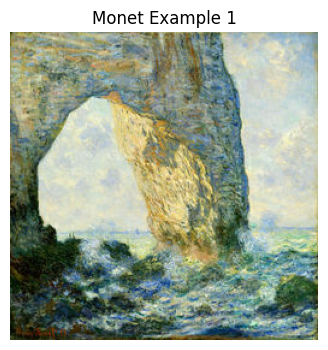

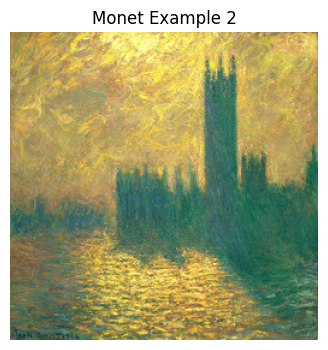

Two example photos:


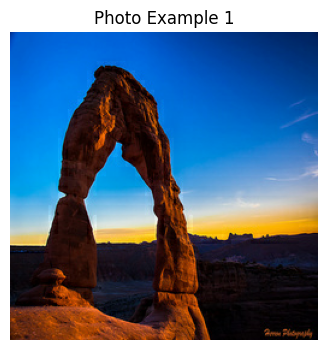

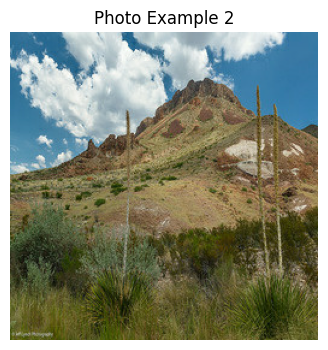

In [3]:
def display_image(image, title=None):
    image = (image + 1) / 2  #denormalize for display
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

#first two examples from each dataset
monet_iterator = iter(monet_ds)
monet_example1 = next(monet_iterator)
monet_example2 = next(monet_iterator)

photo_iterator = iter(photo_ds)
photo_example1 = next(photo_iterator)
photo_example2 = next(photo_iterator)

#displaying images
print("Two example Monets:")
display_image(monet_example1[0].numpy(), title="Monet Example 1")
display_image(monet_example2[0].numpy(), title="Monet Example 2")

print("Two example photos:")
display_image(photo_example1[0].numpy(), title="Photo Example 1")
display_image(photo_example2[0].numpy(), title="Photo Example 2")

Looks good. We can move into building our model.

<h2>3. Building a GAN Model</h2>

I considered using a DCGAN model for this assignment, but I decided against it because DCGAN was built to generate images, not to transform them. (Generating images was an option for this challenge, but I think we'll have better luck transforming the photos provided.) It could probably be modified to work, but CycleGAN was designed to work with unpaired image-to-image transformation, meaning it can take in the small set of Monet images and the big set of photos and be trained to make the photos look like the Monets. 

(It also does the reverse — makes the Monets look like photos — which we won't need to use as output in this project, but which will make the model stronger and might be cool to check out! This "cycle" aspect of CycleGAN is why we'll need to build two generators and two discriminators instead of just one.)

We'll do this in four steps, as outlined in the TensorFlow CycleGAN tutorial. 

a. Build generators (we'll use a modified unet generator type) and discriminators

b. Define loss functions for the discriminators, generators, and cycle function (this makes sure that images turned into photos and then turned back resemble the original image, and vice versa)

c. Compile the models, define a training loop. The training loop will itself have four steps: get predictions, calculate loss, calculate gradients using backpropagation, apply gradients to optimizer

d. Train the models

<h3>a. Build generators and discriminators</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0997534..4.01828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.549573..3.9618878].


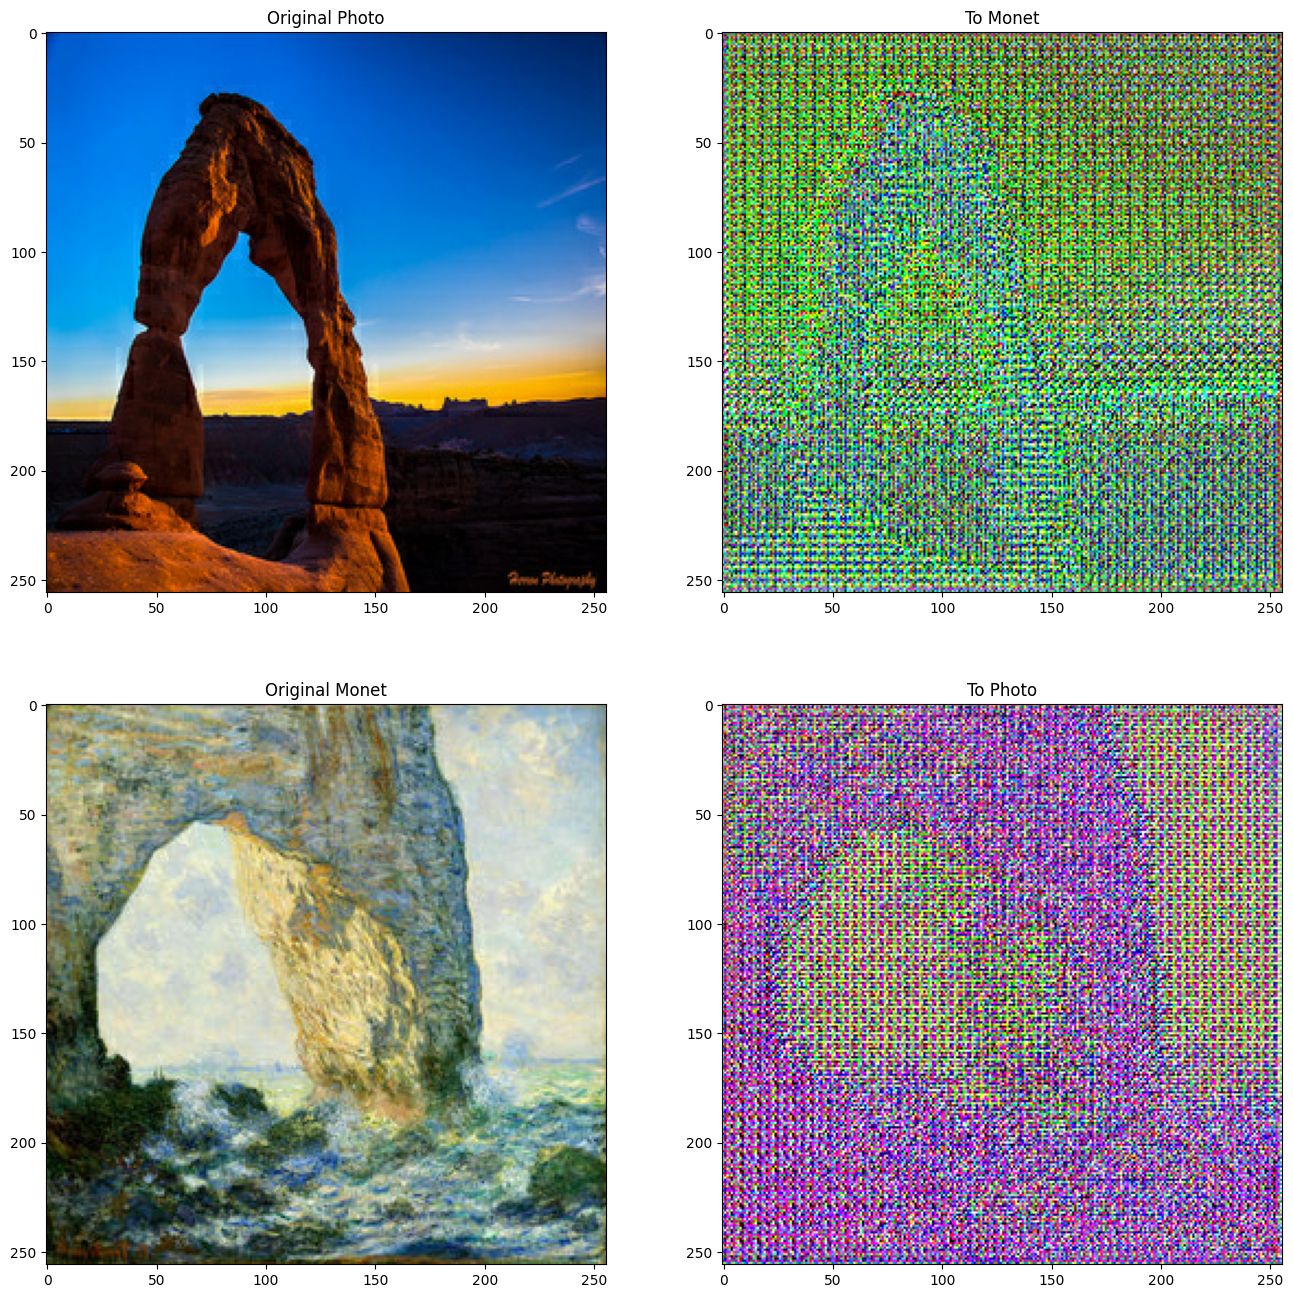

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 1
OUTPUT_CHANNELS = 3
EPOCHS = 50
CHECKPOINT = '/Users/206509/CU/machine-learning/deep-learning/monet/checkpoints/checkpoint'


generator_ptm = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_mtp = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_photo = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_monet = pix2pix.discriminator(norm_type='instancenorm', target=False)

to_monet = generator_ptm(example_photo)
to_photo = generator_mtp(example_monet)
plt.figure(figsize=(16, 16))
contrast = 8

imgs = [example_photo, to_monet, example_monet, to_photo]
title = ['Original Photo', 'To Monet', 'Original Monet', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()


Not too good yet, but the basic idea is working!

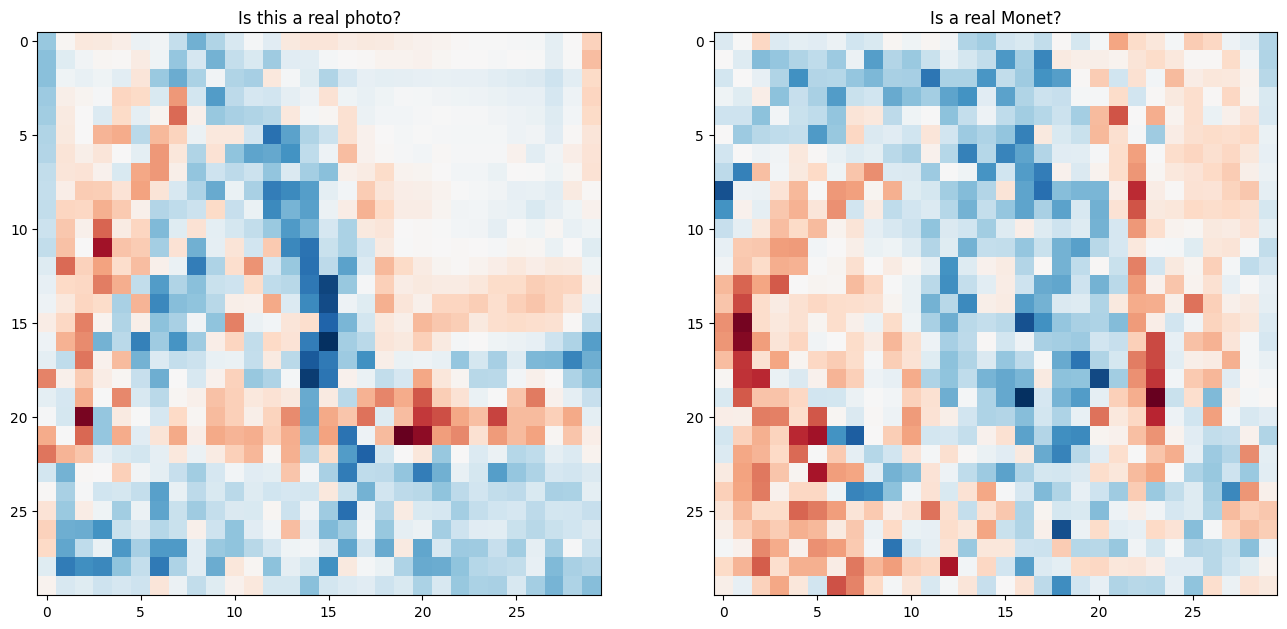

In [5]:
plt.figure(figsize=(16, 16))

plt.subplot(121)
plt.title('Is this a real photo?')
plt.imshow(discriminator_photo(example_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Monet?')
plt.imshow(discriminator_monet(example_monet)[0, ..., -1], cmap='RdBu_r')

plt.show()

<h3>b. Define loss functions</h3>

In [6]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

generator_ptm_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_mtp_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#checkpointing
checkpoint_dir = '/Users/206509/CU/machine-learning/deep-learning/monet/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_ptm=generator_ptm,
                                  generator_mtp=generator_mtp,
                                  discriminator_photo=discriminator_photo,
                                  discriminator_monet=discriminator_monet,
                                  generator_ptm_optimizer=generator_ptm_optimizer,
                                  generator_mtp_optimizer=generator_mtp_optimizer,
                                  discriminator_photo_optimizer=discriminator_photo_optimizer,
                                  discriminator_monet_optimizer=discriminator_monet_optimizer)

<h3>c. Define a training loop</h3>

In [7]:
#define a function to generate input/prediction pairs
def generate_images(model, input):
    prediction = model(input)

    plt.figure(figsize=(16, 16))

    display_list = [input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [8]:
_ = generator_ptm(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH, 3]))
_ = generator_mtp(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH, 3]))
_ = discriminator_monet(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH, 3]))
_ = discriminator_photo(tf.zeros([1, IMG_HEIGHT, IMG_WIDTH, 3]))

@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:

        #generator ptm translates photo -> monet, and generator mtp translates monet -> photo
        fake_monet = generator_ptm(real_photo, training=True)
        cycled_photo = generator_mtp(fake_monet, training=True)
        
        fake_photo = generator_mtp(real_monet, training=True)
        cycled_monet = generator_ptm(fake_photo, training=True)
        
        #same_monet and same_photo are used for identity loss
        same_monet = generator_ptm(real_monet, training=True)
        same_photo = generator_mtp(real_photo, training=True)
        
        disc_real_monet = discriminator_monet(real_monet, training=True)
        disc_real_photo = discriminator_photo(real_photo, training=True)
        
        disc_fake_monet = discriminator_monet(fake_monet, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)
        
        #calculate the loss
        gen_ptm_loss = generator_loss(disc_fake_monet)
        gen_mtp_loss = generator_loss(disc_fake_photo)
        
        total_cycle_loss = calc_cycle_loss(real_monet, cycled_monet) + calc_cycle_loss(real_photo, cycled_photo)
        
        #total generator loss: adversarial loss + cycle loss + identity loss
        total_gen_ptm_loss = gen_ptm_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_gen_mtp_loss = gen_mtp_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    #calculate gradients for generator and discriminator
    generator_ptm_gradients = tape.gradient(total_gen_ptm_loss, generator_ptm.trainable_variables)
    generator_mtp_gradients = tape.gradient(total_gen_mtp_loss, generator_mtp.trainable_variables)
    
    discriminator_monet_gradients = tape.gradient(disc_monet_loss, discriminator_monet.trainable_variables)
    discriminator_photo_gradients = tape.gradient(disc_photo_loss, discriminator_photo.trainable_variables)
    
    #apply the gradients to the optimizer
    generator_ptm_optimizer.apply_gradients(zip(generator_ptm_gradients, generator_ptm.trainable_variables))
    
    generator_mtp_optimizer.apply_gradients(zip(generator_mtp_gradients, generator_mtp.trainable_variables))
    
    discriminator_monet_optimizer.apply_gradients(zip(discriminator_monet_gradients, discriminator_monet.trainable_variables))
    
    discriminator_photo_optimizer.apply_gradients(zip(discriminator_photo_gradients, discriminator_photo.trainable_variables))

<h3>d. Train the model</h3>

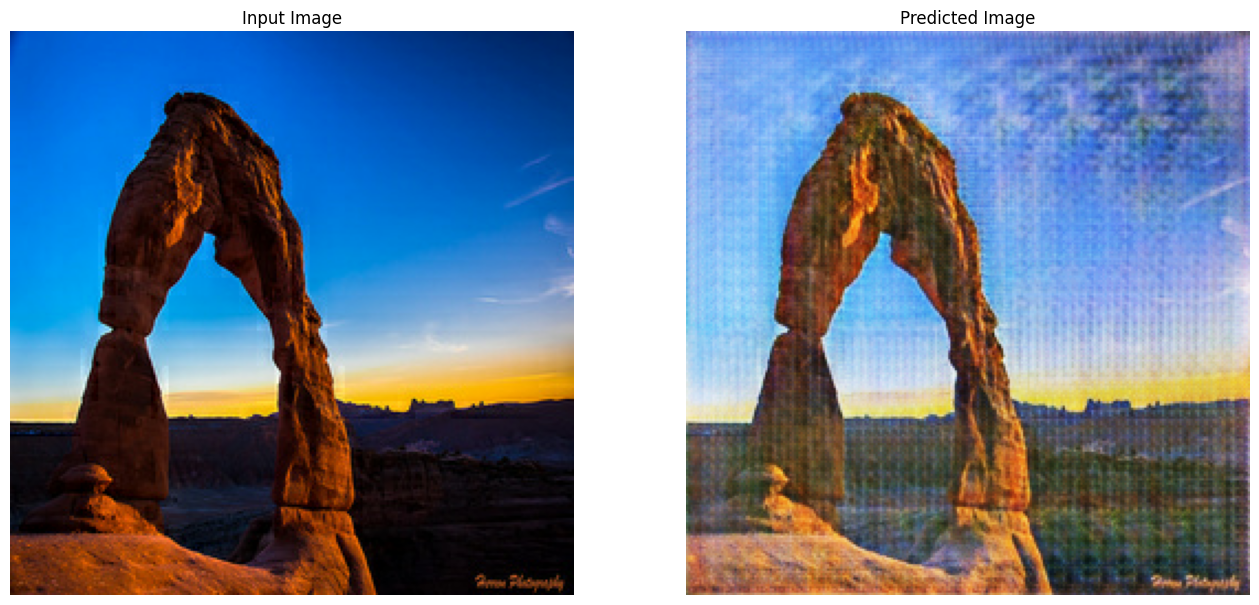

Time taken for epoch 50 is 301.8600890636444 sec



In [9]:
for epoch in range(EPOCHS):
    start = time.time()
    
    n = 0
    for real_monet, real_photo in tf.data.Dataset.zip((monet_ds, photo_ds)):
        train_step(real_photo, real_monet)
        
        if n % 10 == 0:
            print('.', end='')
        n += 1
    
    clear_output(wait=True)
    
    #save checkpoint at the end of each epoch
    checkpoint.save(file_prefix=checkpoint_prefix)

    #use an example photo to generate its Monet-style image
    generate_images(generator_ptm, example_photo)

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [10]:
generator_ptm.save('/Users/206509/CU/machine-learning/deep-learning/monet/generator_ptm.keras')

<h2>4. Results and Analysis</h2>

NOTE ON TUNING:

After running my model once on the photo data provided, I ended up with some really ugly attempts that did not look Monet-like at all, and more importantly did not even look like the final `predicted image` you see just above there, after several epochs of training. 

I had a feeling this was because I wasn't checkpointing and saving my ultimate model correctly, and the images being returned were coming from an untrained version of the model. 

It was much easier to go back and adjust my code rather than to start everything over again, and I thought it would also make my notebook unreadable to do every step a second time. So the previous code that was breaking is not represented here, and the code you've just read and will continue to read is a tuned version of my initial attempt. (I also increased the number of epochs to 50 and let it run overnight.) But as proof of my struggle, here are two of the images it produced.

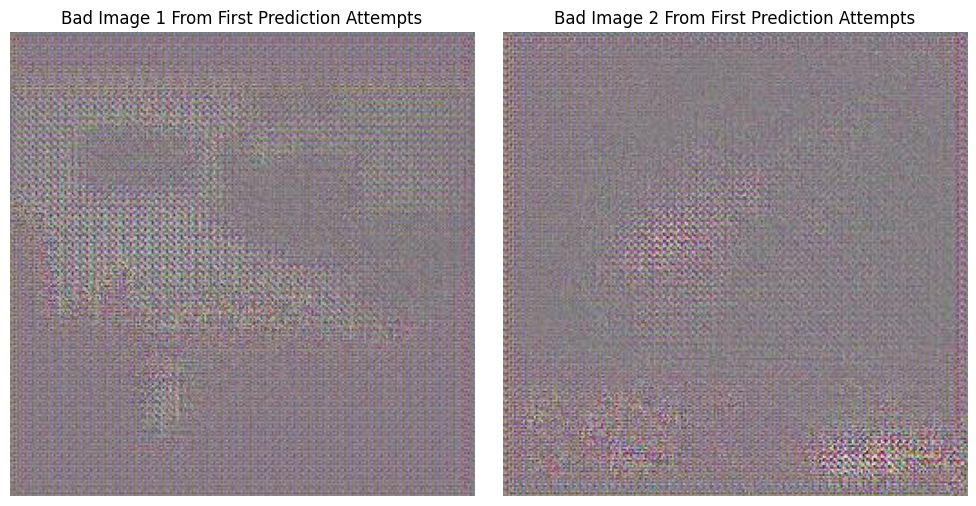

In [15]:
#bad examples from the first run of predictions
bad1_path = '/Users/206509/CU/machine-learning/deep-learning/monet/images302.jpg'
bad2_path = '/Users/206509/CU/machine-learning/deep-learning/monet/images3999.jpg'

image1 = Image.open(bad1_path)
image2 = Image.open(bad2_path)

#create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

axs[0].imshow(image1)
axs[0].axis('off') 
axs[0].set_title('Bad Image 1 From First Prediction Attempts') 

axs[1].imshow(image2)
axs[1].axis('off') 
axs[1].set_title('Bad Image 2 From First Prediction Attempts') 

plt.tight_layout() 
plt.show()

Okay, now that that mess is out of the way … we'll run the trained model on our images and save the Monet-style ones. I had some help on this step from [heyytanay's entry](https://www.kaggle.com/code/heyytanay/tf-paint-like-painter-generate-like-generator), which helped me get through a thorny issue that had been caused by the instance normalization parameter back when we created the generators.

In [12]:
#use the trained model to make predictions — first get weights from checkpoint

#specify the checkpoint directory
checkpoint_dir = '/Users/206509/CU/machine-learning/deep-learning/monet/checkpoints'
checkpoint = tf.train.Checkpoint(generator=generator_ptm)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest_checkpoint).expect_partial()

#save the model weights in keras format
weights_file_path = '/Users/206509/CU/machine-learning/deep-learning/monet/checkpoints/model_weights.weights.h5' 
generator_ptm.save_weights(weights_file_path)


In [27]:
#use the photo-to-monet transformation to monet-ify all the photos
from tqdm import tqdm 

#prepare the output directory
output_dir = '/Users/206509/CU/machine-learning/deep-learning/monet/images'
os.makedirs(output_dir, exist_ok=True)

#process and save images
for i, img in enumerate(tqdm(photo_ds, desc="Processing Images", unit="image")):
    #apply the photo-to-monet transformation
    prediction = generator_ptm(img, training=False)[0].numpy()

    #normalize and convert the prediction
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(output_file_path)

Processing Images: 7038image [09:07, 12.86image/s]


On a third try (after turning out some bad ones, then updating the code to save the model as it trains, then running it with many more epochs), these are pretty decent! Here are a couple of the Monet-ified ones.

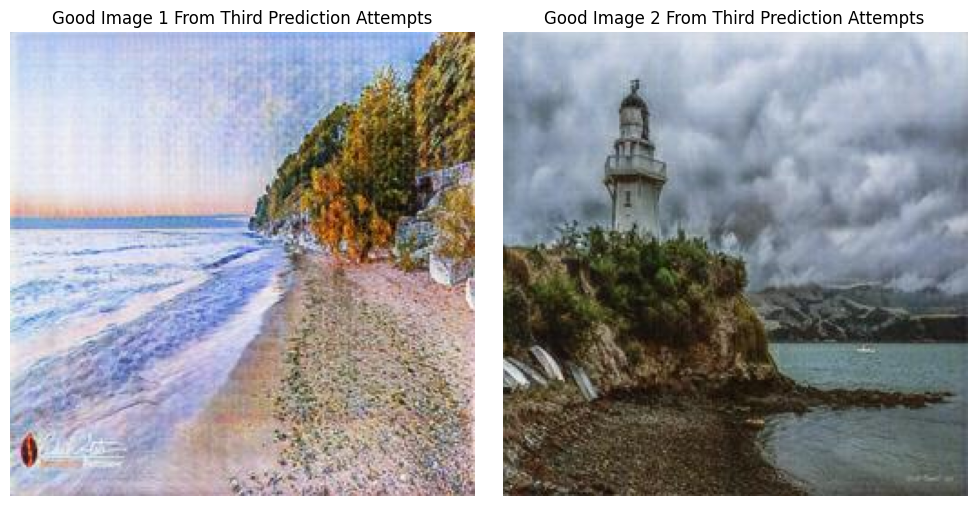

In [16]:
#good examples from the third run of predictions
good1_path = '/Users/206509/CU/machine-learning/deep-learning/monet/images/528.jpg'
good2_path = '/Users/206509/CU/machine-learning/deep-learning/monet/images/1886.jpg'

image1 = Image.open(good1_path)
image2 = Image.open(good2_path)

fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

axs[0].imshow(image1)
axs[0].axis('off') 
axs[0].set_title('Good Image 1 From Third Prediction Attempts') 

axs[1].imshow(image2)
axs[1].axis('off') 
axs[1].set_title('Good Image 2 From Third Prediction Attempts') 

plt.tight_layout()
plt.show()

<h2>5. Discussion and Conclusion</h2>

The first run of my code was a disaster, because it wasn't properly picking up the weights after the training epochs, so it was as though training had never happened. This really impressed upon me the importance of making sure the model is not just learning but retaining what it learns!

After two more tries (one with 5 epochs and then one with 50), I was pretty happy with how the Monet-ified images came out. CycleGAN worked really well for this project because the training images were unpaired, but I did find myself wondering whether it was actually necessary to go through the process of creating the Montet-to-photo generator and discriminator, too, and whether another type of architecture might have performed as well in the end. Simplifying would have been helpful since the project ended up taking a long time to run, and would be a good goal for future improvement.

<h2>6. References</h2>

The Kaggle competition page recommended visiting Amy Jang's [CycleGAN Tutorial Notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial), which I found helpful.

I had not used TFRec files before this, so the [TensorFlow documentation](https://www.tensorflow.org/tutorials/load_data/tfrecord) on it helped as well.

And the TensorFlow tutorials on [DCGAN architecture](https://www.tensorflow.org/tutorials/generative/dcgan) and [CycleGAN architecture](https://www.tensorflow.org/tutorials/generative/cyclegan) were helpful in building better intuition about GANs in general.

Tanay Mehta's submission, "[Paint like Painter, Generate like Generator](https://www.kaggle.com/code/heyytanay/tf-paint-like-painter-generate-like-generator)," helped me through a problem I was having implementing the trained model to make predictions on `photo_ds`.